# Project 1: Exploratory Data Analysis (EDA)

## Back Story

An email from a potential client:

> Cliff and Roberto -
>
> It was great to meet with you and chat at the event where we recently met and had a nice chat. We’d love to take some next steps to see if working together is something that would make sense for both parties.
>
> As we mentioned, we are interested in harnessing the power of data and analytics to optimize the effectiveness of our street team work, which is a significant portion of our fundraising efforts.
>
> WomenTechWomenYes (WTWY) has an annual gala at the beginning of the summer each year. As we are new and inclusive organization, we try to do double duty with the gala both to fill our event space with individuals passionate about increasing the participation of women in technology, and to concurrently build awareness and reach.
>
> To this end we place street teams at entrances to subway stations. The street teams collect email addresses and those who sign up are sent free tickets to our gala.
>
> Where we’d like to solicit your engagement is to use MTA subway data, which as I’m sure you know is available freely from the city, to help us optimize the placement of our street teams, such that we can gather the most signatures, ideally from those who will attend the gala and contribute to our cause.
>
> The ball is in your court now—do you think this is something that would be feasible for your group? From there we can explore what kind of an engagement would make sense for all of us.
>
> Best,
>
> Karrine and Dahlia
>
> WTWY International

### Data:

 * MTA Data (Google it!)
 * Additional data sources welcome!
  
### Skills:

 * `python` and `pandas`
 * visualizations via Matplotlib & seaborn

### Analysis:

 * Exploratory Data Analysis

### Deliverable/communication:

 * Group presentation (2 people per team) 
 * slide presentation
 * visual and oral communication in group presentations
 * organized project repository
 * 5 min presentation per team

### Objectives:
- Optimize the effectiveness of the client's street team work prior to their annual gala at the beginning of the summer
- Fill the event space with individuals passionate about increasing the participation of women in technology
- The client wants to place street teams at entrances to subway stations. Identify best options for this.
- May want to consider exits as well (if these are distinct).
- Also WHEN! Identify time of day, day of week, etc for each week from now til beginning of summer!
- Help them collect as many attendees as possible, **ideally from those who will attend the gala and contribute to their cause**

## Data Processing

In [4]:
# Run the below lines if missing xlrd package
#import sys
#!conda install --yes --prefix {sys.prefix} xlrd

# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
from palettable.colorbrewer.sequential import RdPu_3

In [5]:
### Helper functions
def get_data(link):
    '''
    Takes as input a link to a dataset
    Outputs data as a dataframe
    '''
    data = pd.read_csv(link)
    return data

def process_data(df):
    '''Cleans and processes raw data
    Takes as input raw turnstile dataframe
    Outputs cleaned and processed dataframe with more useful features
    '''
    data = df.copy()

    # Removes white space from column names
    data.rename(columns=lambda x: x.strip(), inplace=True)

    # Create column of datetime objects for each row
    f = '%m/%d/%Y%H:%M:%S'
    data['TIMESTAMP'] = pd.to_datetime(data['DATE'] + data['TIME'], format=f)
    data['DATE'] = pd.to_datetime(data['DATE'], format='%m/%d/%Y')
    # Create column with day of the week
    data['DAY'] = data['DATE'].dt.day_name()
    
    # Remove bad DESC rows and reset index
    data = data[data['DESC'] == 'REGULAR'].reset_index()

    # Rename stations with problematic names
    data = data.apply(rename_station, axis=1)
    
    # Calculate row diffs
    cols_to_diff = ['TIMESTAMP', 'ENTRIES', 'EXITS']
    new_cols = ['TIME_DELTA', 'TURNSTILE_ENTRIES', 'TURNSTILE_EXITS']
    data[new_cols] = data.groupby(by=['STATION', 'C/A', 'SCP'])[cols_to_diff].diff()

    # Calculate time in hours since last entry
    data['HOURS'] = data['TIME_DELTA'] / np.timedelta64(1, 'h')

    # Calculate entries per hour for given turnstile
    data['TURNSTILE_ENTRY_RATE'] = data['TURNSTILE_ENTRIES'] / data['HOURS']
    
    # Filter data to useful rows
    f = (data['TURNSTILE_ENTRY_RATE'] < 3600) & (data['TURNSTILE_ENTRY_RATE'] > 0)
    filtered_data = data[f].reset_index()

    # Narrow df to relevant columns
    cols = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
            'TIMESTAMP', 'DATE', 'DAY', 'TIME', 'TIME_DELTA', 
            'ENTRIES', 'EXITS', 'TURNSTILE_ENTRIES', 'HOURS', 'TURNSTILE_ENTRY_RATE']
    
    return filtered_data[cols]

def rename_station(row):
    '''Modifies names of stations that have been identified as ambiguous
    Takes as input row of dataframe
    Outputs row with modified station name
    '''
    stations = ['34 ST-PENN STA', '23 ST', '72 ST', '86 ST', '96 ST', 
                '103 ST', '116 ST', '125 ST', 'CANAL ST', 'CHAMBERS ST']
    for station in stations:
        if row['STATION'] == station:
            row['STATION'] = (
                row['STATION'] + '\nLINES ' + row['LINENAME'])
            
    if row['STATION'] == 'FULTON ST':
        if 'G' in row['LINENAME']:
            row['STATION'] = 'FULTON ST\nLINE G'
            
    if row['STATION'] == '14 ST':
        if '123' in row['LINENAME']:
            row['STATION'] = '14 ST\nLINE 123FLM'
        else:
            row['STATION'] = (
                row['STATION'] + '\nLINES ' + row['LINENAME'])     
    
    return row


In [6]:
# Download data for turnstile traffic between 6/16/2018 - 6/23/2018
raw_data = get_data('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180623.txt')
raw_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,6658725,2257032
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,6658747,2257036
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,6658766,2257068
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,12:00:00,REGULAR,6658866,2257139
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,16:00:00,REGULAR,6659043,2257188


In [7]:
# Apply processing functions to data
data = process_data(raw_data)
data.sample()

,C/A,UNIT,SCP,STATION,LINENAME,TIMESTAMP,DATE,DAY,TIME,TIME_DELTA,ENTRIES,EXITS,TURNSTILE_ENTRIES,HOURS,TURNSTILE_ENTRY_RATE
44275,N076,R111,00-06-00,23 ST\nLINES CE,CE,2018-06-16 04:00:00,2018-06-16,Saturday,04:00:00,04:00:00,2799759,1023147,74.0,4.0,18.5


In [ ]:
# Weekly rates
weekly_riders = (
    data.groupby(by=['STATION'])['TURNSTILE_ENTRIES']
    .sum()
    .reset_index()
    .sort_values(by='TURNSTILE_ENTRIES', ascending=False)
)

# Set value for number of top stations to narrow down to
top_n = 7

# Display top n stations by week
display(weekly_riders.head(top_n))

### Data  Visualization

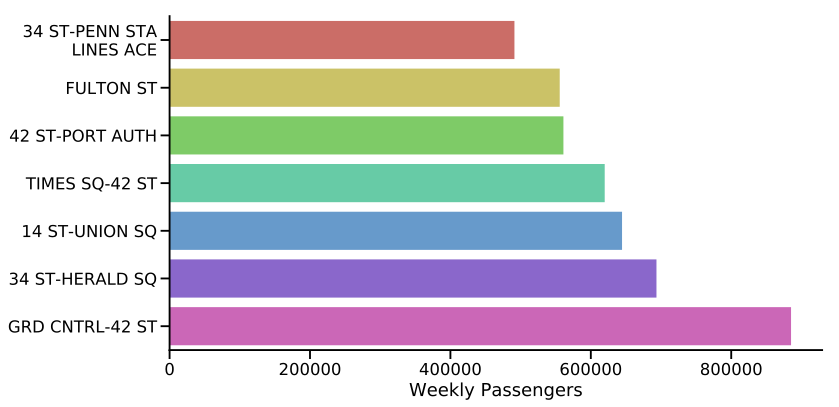

In [94]:
# Create barplot of top n stations by week
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='TURNSTILE_ENTRIES', y='STATION', orient='h', 
            palette='hls', 
            data=weekly_riders.head(top_n).sort_values(by='TURNSTILE_ENTRIES'), ax=ax)

# Figure formatting
ax.set_xlabel('Weekly Passengers')#, fontsize=18)
ax.set_ylabel('')
sns.despine()
plt.tight_layout()
fig.savefig("top_stations_per_week.png", transparent=True, bbox_inches='tight')

In [171]:
# Create df of rides per station per day
daily_riders = (
    data.groupby(by=['STATION', 'DATE'])['TURNSTILE_ENTRIES']
    .sum()
    .reset_index()
)

# Create list of top n stations by highest daily riders
top_stations = daily_riders.sort_values(by='TURNSTILE_ENTRIES', ascending=False)
top_n_stations_list = top_stations['STATION'].unique()[:top_n]
    
# Create dataframe containing only top n stations
f = (top_stations['STATION'].isin(top_n_stations_list))
top_n_stations = top_stations[f].sort_values(by=['DATE', 'TURNSTILE_ENTRIES']).reset_index(drop=True)
top_n_stations['DAY'] = top_n_stations['DATE'].dt.day_name()
top_n_stations.head(top_n)

,STATION,DATE,TURNSTILE_ENTRIES,DAY
0,34 ST-PENN STA\nLINES ACE,2018-06-16,30855.0,Saturday
1,FULTON ST,2018-06-16,36453.0,Saturday
2,TIMES SQ-42 ST,2018-06-16,45136.0,Saturday
3,42 ST-PORT AUTH,2018-06-16,46949.0,Saturday
4,GRD CNTRL-42 ST,2018-06-16,48947.0,Saturday
5,34 ST-HERALD SQ,2018-06-16,53959.0,Saturday
6,14 ST-UNION SQ,2018-06-16,59243.0,Saturday


In [10]:
# Pivot top n station dataframe to heatmappable format
top_n_pivot = (top_n_stations.pivot(
    index='STATION', 
    columns='DAY', 
    values='TURNSTILE_ENTRIES'))
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
top_n_pivot = top_n_pivot.reindex(index=top_n_stations_list, columns=day_labels)
top_n_pivot

DAY,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
STATION,,,,,,,
GRD CNTRL-42 ST,46727.0,152844.0,162427.0,161895.0,163445.0,148921.0,48947.0
34 ST-HERALD SQ,56132.0,109757.0,116197.0,120227.0,121497.0,115742.0,53959.0
14 ST-UNION SQ,57411.0,96469.0,105403.0,110782.0,106881.0,108292.0,59243.0
TIMES SQ-42 ST,55115.0,94193.0,102751.0,106693.0,108909.0,106992.0,45136.0
FULTON ST,31837.0,91978.0,98736.0,100609.0,100520.0,95583.0,36453.0
42 ST-PORT AUTH,52092.0,91810.0,91183.0,92733.0,95107.0,91097.0,46949.0
34 ST-PENN STA\nLINES ACE,35293.0,85098.0,84525.0,85874.0,88048.0,81506.0,30855.0


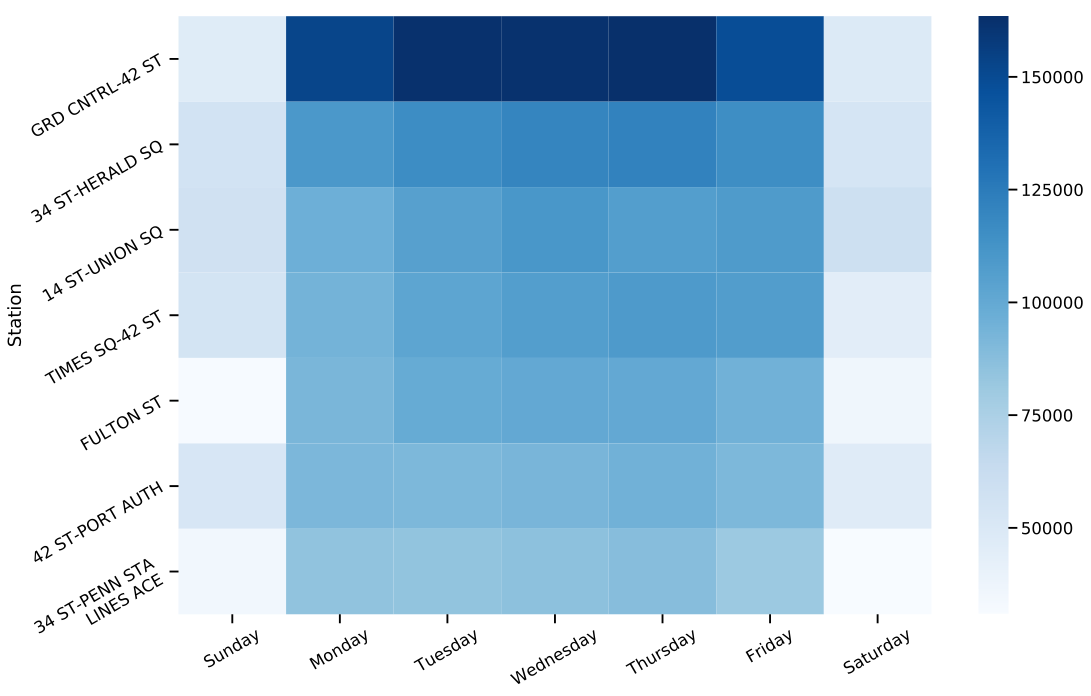

In [103]:
# Create heatmap of daily passengers for top n stations throughout week
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(top_n_pivot, cmap='Blues', ax=ax)

# Figure formatting
plt.xticks(rotation=30) 
plt.yticks(rotation=30) 
ax.set_xlabel('')
ax.set_ylabel('Station')
plt.tight_layout()
fig.savefig("heatmap.png", transparent=True, bbox_inches='tight')

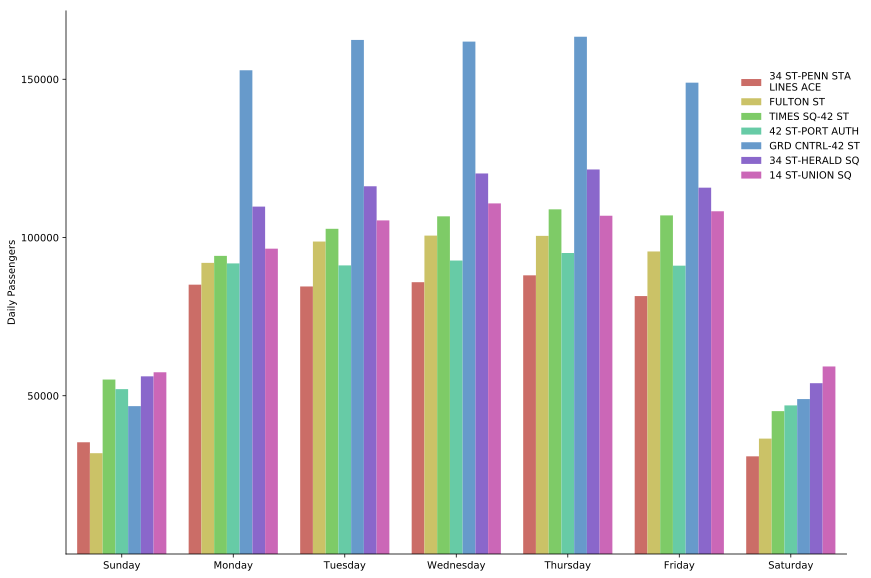

In [12]:
# Create barplot showing daily passengers for top n stations throughout week
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_yticks([50000, 100000, 150000])
ax = sns.barplot(x="DAY", y="TURNSTILE_ENTRIES", 
                 hue="STATION", palette='hls', order=day_labels,
                 data=top_n_stations)

# Figure formatting
ax.set_xlabel('')
ax.set_ylabel('Daily Passengers')
plt.legend(loc=(.86, .68), frameon=False)
sns.despine()
fig.savefig("barplot.png", transparent=True)

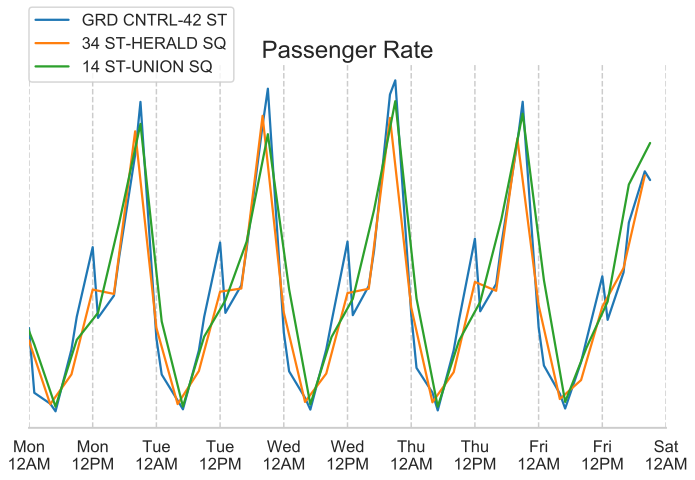

In [170]:
# Create lineplot showing hourly variation of top 3 stations
fig, ax = plt.subplots(figsize=(10, 7))
stations = ['GRD CNTRL-42 ST', '34 ST-HERALD SQ', '14 ST-UNION SQ']

for station in stations:
    sns.lineplot(
        x='TIMESTAMP', 
        y='TURNSTILE_ENTRY_RATE', ci=None,
        data=data[data['STATION'] == station]
    )

# Figure formatting
times = pd.date_range(start='2018-06-18', end='2018-06-23', freq='12H')
xfmt = mdates.DateFormatter('%a\n%-I%p')
ax.set_xlim([datetime.datetime(2018, 6, 18), datetime.datetime(2018, 6, 23)])
ax.xaxis.set_major_formatter(xfmt)
ax.set_xticks(times)
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Passenger Rate', fontsize=24)
plt.legend(labels=stations, loc=(0, .95), frameon=True)
sns.despine(left=True)
plt.tight_layout()
plt.savefig('daily.png', transparent=True)

### Work in Progress

In [85]:
# Create list of top n stations by highest daily riders
top_3_stations_list = top_stations['STATION'].unique()[:3]

# Print out top n stations
print('Top 3 stations:')
for station in top_3_stations_list:
    print(station)
    
# Create dataframe containing only top n stations
f = (data['STATION'].isin(top_3_stations_list))
top_3_stations = data[f].sort_values(by=['DATE', 'TURNSTILE_ENTRIES']).reset_index(drop=True)
top_3_stations['DAY'] = top_3_stations['DATE'].dt.day_name()
top_3_stations = top_3_stations.groupby(by=['STATION','TIMESTAMP'])['TURNSTILE_ENTRIES', 'TURNSTILE_ENTRY_RATE'].sum().reset_index()
top_3_stations[top_3_stations['STATION'].str.contains('GRD')].head(5)

Top 3 stations:
GRD CNTRL-42 ST
34 ST-HERALD SQ
14 ST-UNION SQ


,STATION,TIMESTAMP,TURNSTILE_ENTRIES,TURNSTILE_ENTRY_RATE
82,GRD CNTRL-42 ST,2018-06-16 04:00:00,1772.0,443.00
83,GRD CNTRL-42 ST,2018-06-16 05:00:00,443.0,110.75
84,GRD CNTRL-42 ST,2018-06-16 08:00:00,1290.0,322.50
85,GRD CNTRL-42 ST,2018-06-16 09:00:00,1367.0,341.75
86,GRD CNTRL-42 ST,2018-06-16 12:00:00,7295.0,1823.75


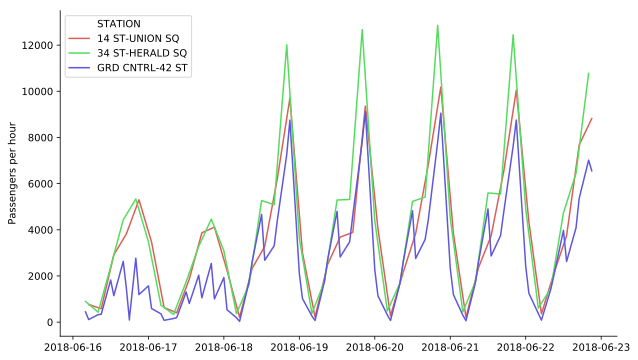

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x='TIMESTAMP', y='TURNSTILE_ENTRY_RATE', hue='STATION', palette='hls', ci=None, data=top_3_stations)

ax.set_xlabel('')
ax.set_ylabel('Passengers per hour')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend(loc='upper right', frameon=False)
# plt.legend(loc=(.86, .68), frameon=False)
sns.despine()
fig.savefig("top_three.png", transparent=True)

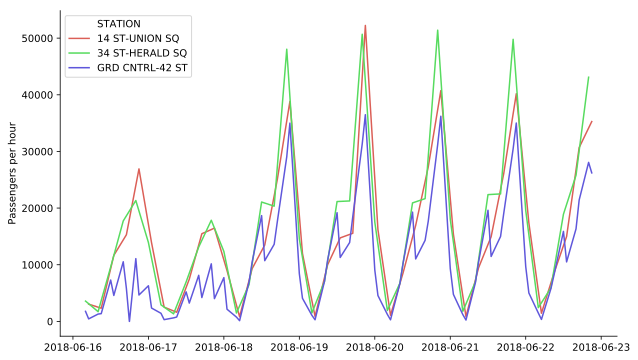

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x='TIMESTAMP', y='TURNSTILE_ENTRIES', hue='STATION', palette='hls', ci=None, data=top_3_stations)

ax.set_xlabel('')
ax.set_ylabel('Passengers per hour')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend(loc='upper right', frameon=False)
# plt.legend(loc=(.86, .68), frameon=False)
sns.despine()
fig.savefig("top_three.png", transparent=True)

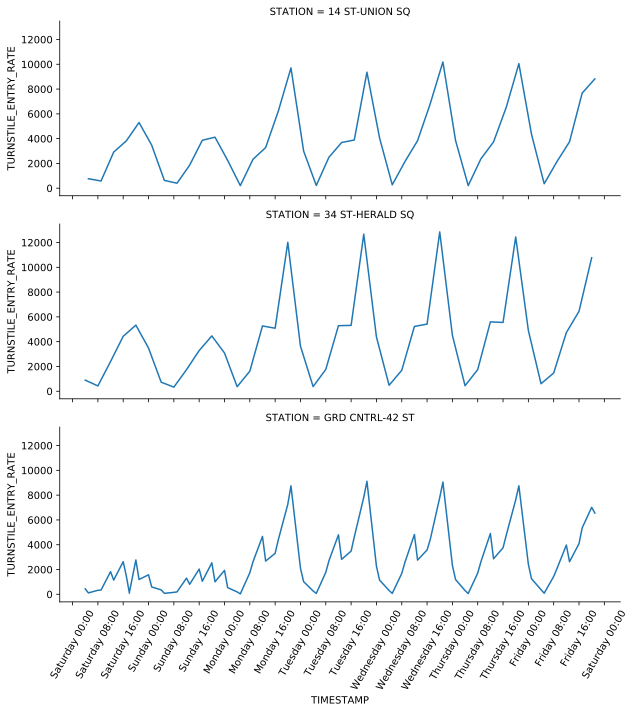

In [78]:
g = sns.FacetGrid(top_3_stations, row='STATION', height=3, aspect=3)
g = g.map(sns.lineplot, 'TIMESTAMP', 'TURNSTILE_ENTRY_RATE')
ax0, ax1, ax2 = g.axes.flat

times = pd.date_range(start='2018-06-16', end='2018-06-23', freq='8H')
xfmt = mdates.DateFormatter('%A %H:%M')
ax2.xaxis.set_major_formatter(xfmt)
ax2.set_xticks(times)
for item in ax2.get_xticklabels():
    item.set_rotation(60)
sns.despine()

## Reference

In [73]:
for station in sorted(data['STATION'].unique()):
    print(station)

1 AV
103 ST
103 ST-CORONA
104 ST
110 ST
111 ST
116 ST
116 ST-COLUMBIA
121 ST
125 ST
135 ST
137 ST CITY COL
138/GRAND CONC
14 ST
14 ST-UNION SQ
145 ST
149/GRAND CONC
14TH STREET
15 ST-PROSPECT
155 ST
157 ST
161/YANKEE STAD
167 ST
168 ST
169 ST
170 ST
174 ST
174-175 STS
175 ST
176 ST
18 AV
18 ST
181 ST
182-183 STS
183 ST
190 ST
191 ST
2 AV
20 AV
207 ST
21 ST
21 ST-QNSBRIDGE
215 ST
219 ST
225 ST
23 ST
231 ST
233 ST
238 ST
25 AV
25 ST
28 ST
3 AV
3 AV 138 ST
3 AV-149 ST
30 AV
33 ST
33 ST-RAWSON ST
34 ST-HERALD SQ
34 ST-HUDSON YD
34 ST-PENN STA
36 AV
36 ST
39 AV
4 AV-9 ST
40 ST LOWERY ST
42 ST-BRYANT PK
42 ST-PORT AUTH
45 ST
46 ST
46 ST BLISS ST
47-50 STS ROCK
49 ST
4AV-9 ST
5 AV/53 ST
5 AV/59 ST
5 AVE
50 ST
51 ST
52 ST
53 ST
55 ST
57 ST
57 ST-7 AV
59 ST
59 ST COLUMBUS
6 AV
61 ST WOODSIDE
63 DR-REGO PARK
65 ST
66 ST-LINCOLN
67 AV
68ST-HUNTER CO
69 ST
7 AV
71 ST
72 ST
72 ST-2 AVE
74 ST-BROADWAY
75 AV
75 ST-ELDERTS
77 ST
79 ST
8 AV
8 ST-NYU
80 ST
81 ST-MUSEUM
82 ST-JACKSON H
85 ST-FOREST PK
86

### Duplicate stations? Investigate
- 103 ST, 103 ST-CORONA
- 14 ST, 14 ST-UNION SQ, 14TH STREET
- 182-183 STS, 183 ST
- 21 ST, 21 ST-QNSBRIDGE
- 57 ST, 57 ST-7 AV
- 86 ST, 86 ST-2 AVE
- 96 ST, 96 ST-2 AVE
- BEVERLEY ROAD, BEVERLY RD
- BROADWAY, BROADWAY JCT
- JAMAICA CENTER, JFK JAMAICA CT1
- NEW LOTS, NEW LOTS AV
- PATH NEW WTC, PATH WTC 2
- VAN SICLEN AV, VAN SICLEN AVE

Field Description

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS


- C/A      = Control Area (A002)
- UNIT     = Remote Unit for a station (R051)
- SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
- STATION  = Represents the station name the device is located at
- LINENAME = Represents all train lines that can be boarded at this station. Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.
- DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
- DATE     = Represents the date (MM-DD-YY)
- TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
- DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
- ENTRIES  = The comulative entry register value for a device
- EXITS    = The cumulative exit register value for a device

Example:
The data below shows the entry/exit register values for one turnstile at control area (A002) from 09/27/14 at 00:00 hours to 09/29/14 at 00:00 hours

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS

A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,00:00:00,REGULAR,0004800073,0001629137

In [90]:
station_data = pd.read_excel('http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls')

In [111]:
sorted(station_data['Station'].unique())

['1 AVE',
 '103 ST',
 '103 ST-CORONA',
 '104 ST',
 '110 ST',
 '110 ST-CATHEDRL',
 '110 ST-CPN',
 '111 ST',
 '116 ST',
 '116 ST-COLUMBIA',
 '121 ST',
 '125 ST',
 '135 ST',
 '137 ST-CITY COL',
 '138 ST-3 AVE',
 '138 ST-GR CONC',
 '14 ST',
 '14 ST-6 AVE',
 '14 ST-UNION SQ',
 '145 ST',
 '148 ST-LENOX',
 '149 ST-3 AVE',
 '149 ST-GR CONC',
 '14TH STREET',
 '15 ST-PROSPECT',
 '155 ST',
 '157 ST',
 '161 ST-YANKEE',
 '163 ST-AMSTERDM',
 '167 ST',
 '168 ST-BROADWAY',
 '169 ST',
 '170 ST',
 '174 ST',
 '174-175 ST',
 '175 ST',
 '176 ST',
 '18 AVE',
 '18 ST',
 '181 ST',
 '182-183 ST',
 '183 ST',
 '190 ST',
 '191 ST',
 '2 AVE',
 '2 BDWY CUST SRV',
 '20 AVE',
 '207 ST',
 '21 ST',
 '215 ST',
 '219 ST',
 '22 AVE-BAY PKY',
 '225 ST',
 '23 ST',
 '23 ST-5 AVE',
 '23 ST-6 AVE',
 '231 ST',
 '233 ST',
 '238 ST',
 '242 ST',
 '25 AVE',
 '25 ST',
 '28 ST',
 '28 ST-BROADWAY',
 '3 AVE',
 '33 ST',
 '33 ST/RAWSON ST',
 '34 ST-HERALD SQ',
 '34 ST-PENN STA',
 '36 ST',
 '4 AVE',
 '40 ST-LOWERY ST',
 '42 ST-BRYANT PK',